<a href="https://colab.research.google.com/github/nedelculiviu95/cnn-detecting-lung-opacities/blob/master/ChestXray_DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install pydicom
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2, glob, pylab, random, os, pydicom
import matplotlib.pyplot as plt
from random import randint
from pathlib import Path
from skimage import measure
from skimage.transform import resize
from tensorflow import keras
import keras
import csv
from keras.callbacks import *
from os.path import isfile, join

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Using TensorFlow backend.


In [0]:
def parse_data(df):
    """
    Read DataEntry2017 CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'image-name01': {
            'png': path/to/png/file,
            'label': list of labels, 
            'boxes': list of box(es)
            'patient_gender': M or F
            'pattient_age': int
        },
        'image-name-02': {
            'png': path/to/png/file,
            'label': list of labels, 
            'boxes': list of box(es)
            'patient_gender': M or F
            'pattient_age': int
        }, ...

      }
      
    """
    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['Image Index']
        if pid not in parsed:
            labels = row['Finding Labels']
            parsed[pid] = {
                'png': '%s' % pid,
                'label': labels.split("|"),
                'patient_gender': row['Patient Gender'],
                'pattient_age': row['Patient Age']}
        
        #labels = row['Finding Labels']
        #parsed[pid]['label'].append(labels.split("|"))
        
    return parsed
  
  
df = pd.read_csv('/content/gdrive/My Drive/ChestXRay_csv/Data_Entry_2017.csv')
parsed = parse_data(df)

In [18]:
print(parsed['00000032_042.png'])

{'png': '00000032_042.png', 'label': ['No Finding'], 'patient_gender': 'F', 'pattient_age': 55}


#Positive classes

In [24]:
negative_examples = 0
for key, value in parsed.items():
  image = key
  if len(parsed[key]['label']) == 1:
    if parsed[key]['label'][0] == 'No Finding':
      negative_examples += 1

positive_examples = len(parsed) - negative_examples
print("Total examples: ", len(parsed))
print("Negative examples: ", negative_examples)
print("Positive examples: ", positive_examples)

print(round((negative_examples / len(parsed)) * 100, 2),'% of the images are normal - do disease')
print(round((positive_examples / len(parsed)) * 100, 2),'% of the images are positive - disease is present')

Total examples:  112120
Negative examples:  60361
Positive examples:  51759
53.84 % of the images are normal - do disease
46.16 % of the images are positive - disease is present


#Plotting data distribution

{'No Finding': 60361, 'Atelectasis': 11559, 'Cardiomegaly': 2776, 'Effusion': 13317, 'Infiltration': 19894, 'Mass': 5782, 'Nodule': 6331, 'Pneumonia': 1431, 'Pneumothorax': 5302, 'Consolidation': 4667, 'Edema': 2303, 'Emphysema': 2516, 'Fibrosis': 1686, 'Pleural_Thickening': 3385, 'Hernia': 227}


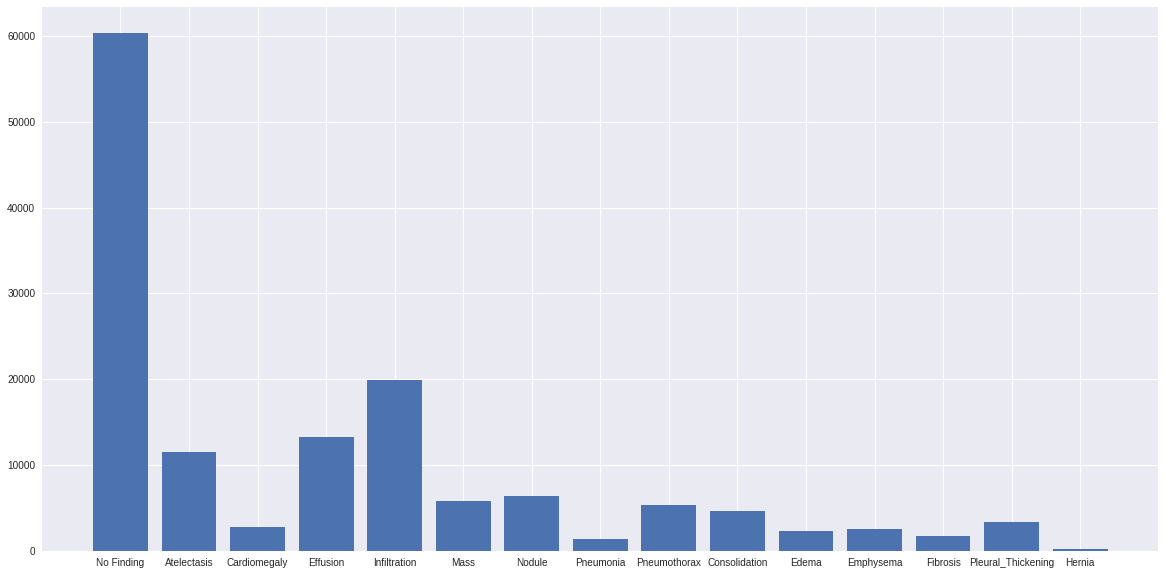

In [45]:
def disease_distribution(parsed):
  dictionary = {'No Finding': 0, 'Atelectasis': 0, 'Cardiomegaly': 0, 'Effusion': 0, 'Infiltration':0, 
                'Mass': 0, 'Nodule': 0, 'Pneumonia': 0, 'Pneumothorax': 0, 'Consolidation': 0,
               'Edema':0, 'Emphysema':0, 'Fibrosis': 0, 'Pleural_Thickening': 0, 'Hernia': 0}
  for key, value in parsed.items():
    labels = parsed[key]['label']
    for item in (labels):
      dictionary[item] += 1
      
  return dictionary


disease_count = disease_distribution(parsed)
print(disease_count)

plt.figure(figsize=(20,10))
plt.bar(range(len(disease_count)), list(disease_count.values()), width=0.8, align='center')
plt.xticks(range(len(disease_count)), list(disease_count.keys()))


plt.show()

In [50]:
df = pd.DataFrame.from_dict(disease_count, orient='index')
print(df)

                        0
No Finding          60361
Atelectasis         11559
Cardiomegaly         2776
Effusion            13317
Infiltration        19894
Mass                 5782
Nodule               6331
Pneumonia            1431
Pneumothorax         5302
Consolidation        4667
Edema                2303
Emphysema            2516
Fibrosis             1686
Pleural_Thickening   3385
Hernia                227
